# Downloading the Dataset

In [1]:
#!wget https://myblog-imgs.s3.amazonaws.com/project/dataset.zip

In [2]:
#!unzip dataset.zip

# Importing Modules

Importing all the modules which we are going to use for this problem.

In [3]:
import torch
import numpy as np
import random
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F
import operator
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Resize
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import Image as IPImage


# Function to split the dataset into test and train

This function is used to create the test and training split of the dataset. 


In [4]:
def train_val_dataset(dataset, val_split=0.20):
    '''
    input: takes an torchvision.datasets.ImageFolder object
    return: a dict with "test" and "train" key, with the split of data, w.r.t split ratio(test_size)
    '''
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['test'] = Subset(dataset, val_idx)
    
    return datasets

# Some helper functions to print the image

In [5]:
def imshow(img,text=None,should_save=False):
    '''
    This function takes an Image and prints the image. 
    '''
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# Dataset Class 
## Triplet Pair -> {`Anchor`, `Positive` and `Negative`}

Dataset generates a pair of images. 
    - With label of 0 for positive pair(sketch and photo are same) 
    - With lebel of 1 for imposter pair(sketch and photo are different) 

In [6]:
IPImage(url='https://myblog-imgs.s3.amazonaws.com/project/match_mismatch.png')

In [7]:
class SNDataset(Dataset):
    '''
    This class is used to generate an image tuple as a generator, which will randomly generate 
    a pair of (Image, Sketch, Match/Mismatch)
    '''
    def __init__(self,photoFolderDataset, sketchFolderDataset, 
                 photoFolderIndex, sketchFolderIndex,
                 transform=None, should_invert=False):
        
        self.photoFolderDataset = photoFolderDataset   
        self.sketchFolderDataset = sketchFolderDataset
        
        self.photoFolderIndex = photoFolderIndex
        self.sketchFolderIndex = sketchFolderIndex
        
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        '''
        This generator helps to randomly pick a pair of `Sketch and `Image`, which may be of same same 
        class or different class. Since we need to make sure, this generates, pair with roughly 
        same probability, with around 50% of the images of same class and rest of the other class.
        '''
        
        # Randomly picking the 1st sketch from the sketch dataset 
        img0_tuple = random.choice(self.sketchFolderDataset.imgs) 

        # This kind of assures we have roughly equal propability of the same and different class
        should_get_same_class = random.randint(0,1) 
        
        if should_get_same_class:
            while True:
                #  Looping till it gets the same class image is found
                img1_tuple = random.choice(self.photoFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                # Looping till it gets some different class image is found
                img1_tuple = random.choice(self.photoFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # Returning the pair of (image, sketch, label) with a label indicating if its a match or mismatch
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return sum([len(self.photoFolderDataset.imgs), len(self.sketchFolderDataset.imgs)])

# Creating the DataLoader for TRAINING
Loading the data set for both photo and sketch, and split for test and training

### Dataset Path

In [8]:
# Path for the Photo and Sketch 

photo_main_dir = "dataset/photo"
sketch_main_dir = "dataset/sketch"

### For Photo
Spliting the Photo dataset into test and train

In [9]:
dataset_p = ImageFolder(photo_main_dir)

dataset_photo = train_val_dataset(dataset_p)
dataset_photo_train_idx = dataset_photo['train'].indices    # Indices of photos for training from the dataset_p
dataset_photo_test_idx = dataset_photo['test'].indices      # Indices of photos for testing from the dataset_p

### For Sketch
Spliting the Sketch dataset into test and train

In [10]:
dataset_s = ImageFolder(sketch_main_dir)

dataset_sketch = train_val_dataset(dataset_s)
dataset_sketch_train_idx = dataset_sketch['train'].indices  # Indices of sketchs for training from the dataset_s
dataset_sketch_test_idx = dataset_sketch['test'].indices    # Indices of sketchs for testing from the dataset_s

### Creating the `SNDataset` object instance

In [11]:
mydataset = SNDataset(photoFolderDataset=dataset_p,
                      sketchFolderDataset=dataset_s,
                      photoFolderIndex=dataset_photo_train_idx,
                      sketchFolderIndex=dataset_sketch_train_idx,
                      transform=transforms.Compose([transforms.Resize((100,100)),
                                                    transforms.ToTensor()
                                                   ]),
                     )

# Some sample to view the Images 


Creating the `DataLoader` with the custom `SNDataset` object

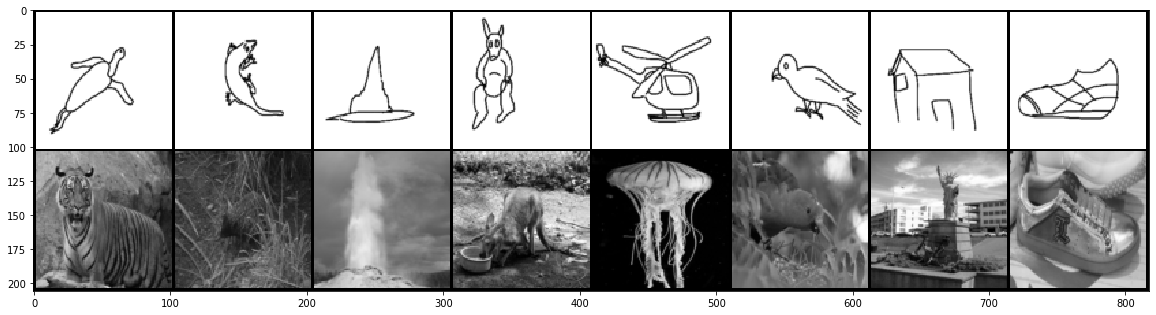

Class of the above pair of images, 0 indicates MATCH, 1 indicates MISMATCH

[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [12]:
my_dataloader = DataLoader(mydataset,
                           shuffle=True,
                           num_workers=8,
                           batch_size=8)
dataiter = iter(my_dataloader)

one_batch = next(dataiter)
concatenated = torch.cat((one_batch[0],one_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print("Class of the above pair of images, 0 indicates MATCH, 1 indicates MISMATCH\n")
print(one_batch[2].numpy())

# CNN Definition (Siamese Network)
Defining the CNN for the `Siamese Network`

In [13]:
IPImage(url='https://myblog-imgs.s3.amazonaws.com/project/cnn_network.png')

In [14]:
class SN(nn.Module):
    '''
    Network used is a simple CNN, with:
    Conv2d-> ReLU -> BatchNorm2d -> Conv2d -> ReLU -> BatchNorm2d -> Conv2d -> ReLU -> BatchNorm2d

    Followed by a fully connected layer:
    Linear -> ReLU -> Linear -> ReLU -> Linear
    '''
    def __init__(self):
        super(SN, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Contrastive Loss

In [15]:
class CLoss(torch.nn.Module):
    '''
    Since, we are using Siamese Architecture and we are not classifying the input images, 
    but to needed a mechanism to differentiate between them. So, instead of using any classification 
    loss function, this architecture is better suited to use a contrastive function. 
    And in a nutshell this function simply evaluates how well the network is able to distinguish 
    a given pair of images.
    '''
    def __init__(self, margin=2.0):
        super(CLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Training
Starting the training

### Setting  `hyperparameters`

In [32]:
train_batch_size = 128
train_number_epochs = 100
learning_rate = 0.0005

train_dataloader = DataLoader(mydataset,
                              shuffle=True,
                              num_workers=32,
                              batch_size=train_batch_size)

### Setting the `Loss Function`, `Optimizer` and `CNN`

In [33]:
net = SN().cuda()
criterion = CLoss()
optimizer = optim.Adam(net.parameters(),lr = learning_rate)

In [34]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.3691339492797852

Epoch number 0
 Current loss 1.1204288005828857

Epoch number 0
 Current loss 1.1500670909881592

Epoch number 0
 Current loss 1.109127163887024

Epoch number 0
 Current loss 1.0000309944152832

Epoch number 0
 Current loss 1.0802875757217407

Epoch number 0
 Current loss 1.1143362522125244

Epoch number 1
 Current loss 0.9585288166999817

Epoch number 1
 Current loss 1.0355656147003174

Epoch number 1
 Current loss 0.991644561290741

Epoch number 1
 Current loss 0.9601932764053345

Epoch number 1
 Current loss 1.008708119392395

Epoch number 1
 Current loss 0.9663068056106567

Epoch number 1
 Current loss 1.0332804918289185

Epoch number 2
 Current loss 1.0211207866668701

Epoch number 2
 Current loss 0.9126771688461304

Epoch number 2
 Current loss 0.9592157602310181

Epoch number 2
 Current loss 0.9048250317573547

Epoch number 2
 Current loss 0.9613680243492126

Epoch number 2
 Current loss 0.9744876027107239

Epoch number 2
 Current

Epoch number 23
 Current loss 0.261974573135376

Epoch number 23
 Current loss 0.31308484077453613

Epoch number 23
 Current loss 0.2792346179485321

Epoch number 24
 Current loss 0.2987895607948303

Epoch number 24
 Current loss 0.34120428562164307

Epoch number 24
 Current loss 0.33276766538619995

Epoch number 24
 Current loss 0.2867666482925415

Epoch number 24
 Current loss 0.23258374631404877

Epoch number 24
 Current loss 0.2688200771808624

Epoch number 24
 Current loss 0.23455388844013214

Epoch number 25
 Current loss 0.2451622039079666

Epoch number 25
 Current loss 0.21125513315200806

Epoch number 25
 Current loss 0.26751619577407837

Epoch number 25
 Current loss 0.3326682448387146

Epoch number 25
 Current loss 0.2898574769496918

Epoch number 25
 Current loss 0.26218706369400024

Epoch number 25
 Current loss 0.21472418308258057

Epoch number 26
 Current loss 0.2863459289073944

Epoch number 26
 Current loss 0.21392634510993958

Epoch number 26
 Current loss 0.208196103

Epoch number 46
 Current loss 0.12086781859397888

Epoch number 46
 Current loss 0.14818528294563293

Epoch number 47
 Current loss 0.16049745678901672

Epoch number 47
 Current loss 0.14784234762191772

Epoch number 47
 Current loss 0.12926307320594788

Epoch number 47
 Current loss 0.1490022987127304

Epoch number 47
 Current loss 0.10944943130016327

Epoch number 47
 Current loss 0.10575363039970398

Epoch number 47
 Current loss 0.13302269577980042

Epoch number 48
 Current loss 0.09053251147270203

Epoch number 48
 Current loss 0.16443176567554474

Epoch number 48
 Current loss 0.10674901306629181

Epoch number 48
 Current loss 0.13244622945785522

Epoch number 48
 Current loss 0.1725952923297882

Epoch number 48
 Current loss 0.1436074823141098

Epoch number 48
 Current loss 0.14041389524936676

Epoch number 49
 Current loss 0.1495674103498459

Epoch number 49
 Current loss 0.1044490784406662

Epoch number 49
 Current loss 0.12902545928955078

Epoch number 49
 Current loss 0.1216

Epoch number 69
 Current loss 0.07444147765636444

Epoch number 70
 Current loss 0.0723499208688736

Epoch number 70
 Current loss 0.13932567834854126

Epoch number 70
 Current loss 0.09147214889526367

Epoch number 70
 Current loss 0.10749521106481552

Epoch number 70
 Current loss 0.1089339554309845

Epoch number 70
 Current loss 0.06278891861438751

Epoch number 70
 Current loss 0.089143306016922

Epoch number 71
 Current loss 0.08211582899093628

Epoch number 71
 Current loss 0.09668228775262833

Epoch number 71
 Current loss 0.06216122582554817

Epoch number 71
 Current loss 0.11692027747631073

Epoch number 71
 Current loss 0.08950712531805038

Epoch number 71
 Current loss 0.0778992772102356

Epoch number 71
 Current loss 0.11601120233535767

Epoch number 72
 Current loss 0.08984318375587463

Epoch number 72
 Current loss 0.1727077066898346

Epoch number 72
 Current loss 0.09908647835254669

Epoch number 72
 Current loss 0.0752280130982399

Epoch number 72
 Current loss 0.104149

Epoch number 93
 Current loss 0.07211802899837494

Epoch number 93
 Current loss 0.07290292531251907

Epoch number 93
 Current loss 0.08725012838840485

Epoch number 93
 Current loss 0.06950823962688446

Epoch number 93
 Current loss 0.10204160213470459

Epoch number 93
 Current loss 0.07882142066955566

Epoch number 93
 Current loss 0.07759181410074234

Epoch number 94
 Current loss 0.0962773934006691

Epoch number 94
 Current loss 0.08337313681840897

Epoch number 94
 Current loss 0.07904282212257385

Epoch number 94
 Current loss 0.07376432418823242

Epoch number 94
 Current loss 0.10846282541751862

Epoch number 94
 Current loss 0.055527277290821075

Epoch number 94
 Current loss 0.06511851400136948

Epoch number 95
 Current loss 0.0828540101647377

Epoch number 95
 Current loss 0.08396431803703308

Epoch number 95
 Current loss 0.07422806322574615

Epoch number 95
 Current loss 0.0757405012845993

Epoch number 95
 Current loss 0.06974612176418304

Epoch number 95
 Current loss 0.0

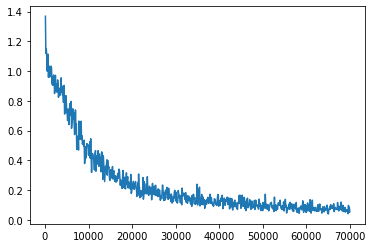

In [35]:
for epoch in range(train_number_epochs):
    '''
    Training Starts here
    '''
    for i, data in enumerate(train_dataloader,0):
        
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        
        optimizer.zero_grad()
        
        output1,output2 = net(img0,img1)
        
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        
        optimizer.step()
        
        if i %100 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=100
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            
show_plot(counter,loss_history)

# Testing(Inference)

In [36]:
def imshow_inference(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    


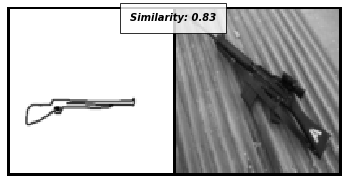

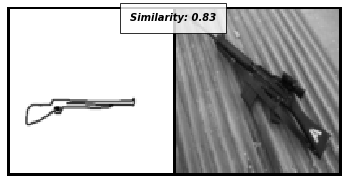

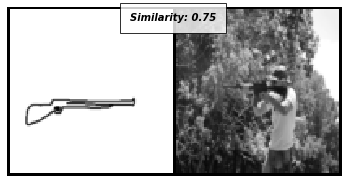

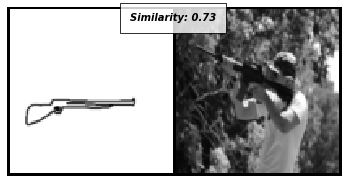

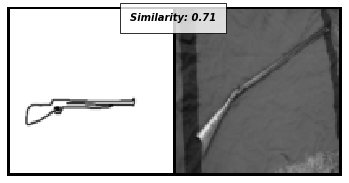

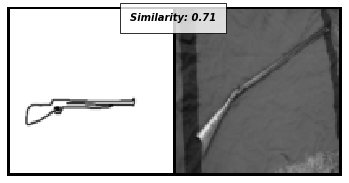

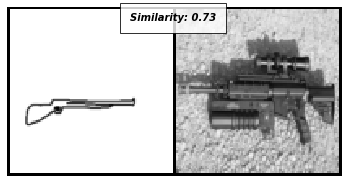

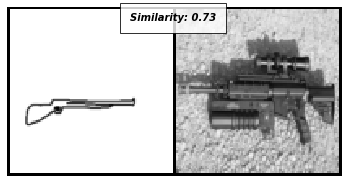

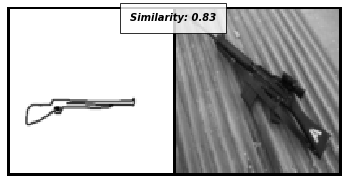

In [44]:
mydataset_test = SNDataset(photoFolderDataset=dataset_p,
                           sketchFolderDataset=dataset_s,
                           photoFolderIndex=dataset_photo_test_idx,
                           sketchFolderIndex=dataset_sketch_test_idx,
                           transform=transforms.Compose([transforms.Resize((100,100)),
                                                         transforms.ToTensor()
                                                        ]),
                           should_invert=False)


test_dataloader = DataLoader(mydataset_test,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

counter = 0
for i in range(len(dataset_photo_train_idx)):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    if euclidean_distance.item() < .3:
        imshow_inference(torchvision.utils.make_grid(concatenated),'Similarity: {:.2f}'.format(1-euclidean_distance.item()))
        counter += 1
    if counter >= 10:
        break

# Saving the Model

In [46]:
# Specify a path
PATH = "myModel.pt"

# Save
torch.save(net, PATH)

# Send the files to AWS S3 Bucket

In [23]:
# bucket = 'myblog-imgs'

In [47]:
import boto3

def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

In [25]:
upload_to_s3("project_v1", "dataset.zip")
upload_to_s3("project_v1", "Sketchy_Inference.ipynb")
upload_to_s3("project_v1", "Sketchy_Training.ipynb")
upload_to_s3("project_v1", PATH)